In [1]:
import numpy as np
from scipy.stats import wasserstein_distance
from scipy import stats
import ot 
import pandas as pd
from scipy.stats import wasserstein_distance, entropy
from scipy.optimize import linprog
import ot
from itertools import combinations
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Functions

In [2]:
def calculate_death_rates(df_deaths, df_exposures):
    """
    Calculate death rates from death counts and population exposures.
    
    Parameters:
    -----------
    df_deaths : DataFrame with columns [country, year, sex, cause, d0, d1, d5, ..., d95p]
    df_exposures : DataFrame with columns [country, year, sex, e0, e1, e5, ..., e95p]
                   Note: exposures do NOT have a 'cause' column (same for all causes)
    
    Returns:
    --------
    DataFrame with columns [country, year, sex, cause, m0, m1, m5, ..., m95p]
    where mx = dx / ex (death rate = deaths / exposure)
    """
    # Get column lists
    death_cols = [col for col in df_deaths.columns if col.startswith('d')]
    exposure_cols = [col for col in df_exposures.columns if col.startswith('e')]
    
    # Verify same number of age columns
    if len(death_cols) != len(exposure_cols):
        raise ValueError("Death and exposure dataframes must have same number of age columns")
    
    # Merge deaths and exposures (exposures don't have 'cause' column)
    merge_cols = ['country', 'year', 'sex']
    df_merged = df_deaths.merge(df_exposures, on=merge_cols, suffixes=('_d', '_e'))
    
    # Calculate death rates for each age group
    id_cols = ['country', 'year', 'sex', 'cause']
    df_rates = df_merged[id_cols].copy()
    
    for i, d_col in enumerate(death_cols):
        e_col = exposure_cols[i]
        
        # Extract age indicator (e.g., '0', '1', '5', '95p')
        age_indicator = d_col[1:]  # Remove 'd' prefix
        m_col = f'm{age_indicator}'
        
        # Find matching columns in merged dataframe
        # Deaths might have suffix if there's a conflict
        if f'{d_col}_d' in df_merged.columns:
            death_col = f'{d_col}_d'
        else:
            death_col = d_col
        
        # Exposures might have suffix if there's a conflict    
        if f'{e_col}_e' in df_merged.columns:
            exposure_col = f'{e_col}_e'
        else:
            exposure_col = e_col
        
        # Calculate rate: mx = dx / ex, handle division by zero
        df_rates[m_col] = np.where(
            df_merged[exposure_col] > 0,
            df_merged[death_col] / df_merged[exposure_col],
            0.0
        )
    
    return df_rates

def wide_to_long(df):
    """
    Convert wide format dataframe to long format,
    preserving all age groups and filling missing values with zero.
    """

    # --- Canonical age structure ---
    age_mapping = {
        'm0': '0',
        'm1': '1-4',
        'm5': '5-9',
        'm10': '10-14',
        'm15': '15-19',
        'm20': '20-24',
        'm25': '25-29',
        'm30': '30-34',
        'm35': '35-39',
        'm40': '40-44',
        'm45': '45-49',
        'm50': '50-54',
        'm55': '55-59',
        'm60': '60-64',
        'm65': '65-69',
        'm70': '70-74',
        'm75': '75-79',
        'm80': '80-84',
        'm85': '85-89',
        'm90': '90-94',
        'm95p': '95+'
    }

    age_order = list(age_mapping.values())
    age_cols = list(age_mapping.keys())

    id_vars = ['country', 'year', 'sex', 'cause']

    # --- Ensure all age columns exist ---
    df = df.copy()
    for col in age_cols:
        if col not in df.columns:
            df[col] = 0

    # --- Keep relevant columns ---
    df_subset = df[id_vars + age_cols]

    # --- Clean numeric values ---
    for col in age_cols:
        df_subset[col] = (
            df_subset[col]
            .replace('.', 0)
            .pipe(pd.to_numeric, errors='coerce')
            .fillna(0)
        )

    # --- Melt ---
    df_long = df_subset.melt(
        id_vars=id_vars,
        value_vars=age_cols,
        var_name='age_code',
        value_name='death_rate'
    )

    # --- Map ages (no NaNs allowed) ---
    df_long['age'] = df_long['age_code'].map(age_mapping)

    # --- Cause aggregation ---
    def categorize_cause(cause):
        if cause == 'S002':
            return 'Cancer'
        elif cause in ['S007', 'S008', 'S009']:
            return 'CVD'
        elif cause == 'S016':
            return 'External'
        else:
            return 'Rest'

    df_long['cause'] = df_long['cause'].apply(categorize_cause)

    # --- Aggregate ---
    df_long = (
        df_long
        .groupby(['country', 'year', 'sex', 'cause', 'age'], as_index=False)
        ['death_rate']
        .sum()
    )

    idx = pd.MultiIndex.from_product(
        [
            df_long['country'].unique(),
            df_long['year'].unique(),
            df_long['sex'].unique(),
            df_long['cause'].unique(),
            age_order
        ],
        names=['country', 'year', 'sex', 'cause', 'age']
    )

    df_long = (
        df_long
        .set_index(['country', 'year', 'sex', 'cause', 'age'])
        .reindex(idx, fill_value=0)
        .reset_index()
    )

    return df_long


def calculate_life_expectancy_from_rates(df_rates, verbose=False):
    """
    Calculate life expectancy at birth from death rates.
    
    Parameters:
    -----------
    df_rates : DataFrame with columns [country, year, sex, cause, m0, m1, m5, ..., m95p]
    verbose : bool, print life expectancies
    
    Returns:
    --------
    DataFrame with columns [country, year, sex, e0] - life expectancy at birth
    """
    # Convert to long format
    df_long = wide_to_long(df_rates)
    
    results = []
    
    # Group by country, year, sex
    for (country, year, sex), group in df_long.groupby(['country', 'year', 'sex']):
        
        # Aggregate death rates by age (sum across all causes)
        total_mx = group.groupby('age', as_index=False)['death_rate'].sum()
        total_mx = total_mx.rename(columns={'death_rate': 'mx_total'})
        
        # Sort ages by midpoint
        age_labels = sorted(total_mx['age'].unique(), key=lambda x: midpoint_from_label(x))
        
        # Create age vector with numeric starting ages for calculating intervals
        age_starts = []
        for lab in age_labels:
            if lab == '0':
                age_starts.append(0)
            elif lab == '1-4':
                age_starts.append(1)
            elif lab.endswith('+'):
                age_starts.append(int(lab.replace('+', '')))
            else:
                age_starts.append(int(lab.split('-')[0]))
        
        # Calculate n (age interval widths)
        n = []
        for i in range(len(age_starts)):
            if i < len(age_starts) - 1:
                n.append(age_starts[i+1] - age_starts[i])
            else:
                n.append(999.0)  # open-ended interval
        
        # Prepare total_mx with life table calculations
        total_mx = total_mx.set_index('age').loc[age_labels].reset_index()
        total_mx['n'] = n
        total_mx['ax'] = total_mx['n'] / 2
        
        # Calculate qx using standard life table formula
        total_mx['qx'] = (total_mx['n'] * total_mx['mx_total']) / \
                         (1 + (total_mx['n'] - total_mx['ax']) * total_mx['mx_total'])
        total_mx['qx'] = total_mx['qx'].clip(upper=1.0)
        
        # Calculate lx 
        radix = 100000
        lx_values = [radix]
        for i in range(len(total_mx) - 1):
            lx_values.append(lx_values[-1] * (1 - total_mx['qx'].iloc[i]))
        total_mx['lx'] = lx_values
        
        # Calculate dx (deaths in interval)
        total_mx['dx'] = total_mx['lx'] * total_mx['qx']
        
        # Calculate Lx (person-years lived in interval)
        total_mx['Lx'] = 0.0
        for i in range(len(total_mx)):
            if i < len(total_mx) - 1:
                total_mx.loc[total_mx.index[i], 'Lx'] = (
                    total_mx.loc[total_mx.index[i], 'n'] * 
                    (total_mx.loc[total_mx.index[i], 'lx'] - total_mx.loc[total_mx.index[i], 'dx'])
                    + total_mx.loc[total_mx.index[i], 'ax'] * total_mx.loc[total_mx.index[i], 'dx']
                )
            else:  # Last age group (open-ended)
                if total_mx.loc[total_mx.index[i], 'mx_total'] > 0:
                    total_mx.loc[total_mx.index[i], 'Lx'] = (
                        total_mx.loc[total_mx.index[i], 'lx'] / total_mx.loc[total_mx.index[i], 'mx_total']
                    )
                else:
                    total_mx.loc[total_mx.index[i], 'Lx'] = 0.0
        
        # Calculate Tx (total person-years lived from age x onwards)
        total_mx['Tx'] = total_mx['Lx'][::-1].cumsum()[::-1]
        
        # Calculate ex (life expectancy at age x)
        total_mx['ex'] = total_mx['Tx'] / total_mx['lx']
        total_mx['ex'] = total_mx['ex'].replace([np.inf, -np.inf], 0)
        
        # Life expectancy at birth
        e0 = total_mx.loc[total_mx.index[0], 'ex']
        
        if verbose:
            print(f"\n{country}, {year}, sex={sex}:")
            print(f"  Life expectancy at birth = {e0:.2f} years")
            print(f"  Sample death rates (mx_total): {total_mx['mx_total'].head(5).tolist()}")
            print(f"  Sample qx values: {total_mx['qx'].head(5).tolist()}")
            print(f"  Sample lx values: {total_mx['lx'].head(5).tolist()}")
            if e0 > 200 or e0 < 20:
                print(f"  WARNING: Unrealistic life expectancy!")
                print(f"  Full life table:")
                print(total_mx[['age', 'mx_total', 'qx', 'lx', 'dx', 'Lx', 'Tx', 'ex']].to_string())
        
        results.append({
            'country': country,
            'year': year,
            'sex': sex,
            'e0': e0
        })
    
    return pd.DataFrame(results)

def midpoint_from_label(label):
    """Convert age group label to midpoint."""
    if label == '0':
        return 0.5
    elif label == '1-4':
        return 2.5
    elif label.endswith('+'):
        base = int(label.replace('+', ''))
        return base + 2.5
    else:
        parts = label.split('-')
        return (int(parts[0]) + int(parts[1])) / 2


def calculate_multi_decrement_life_table(df_long, radix=1.0, verbose=False):
    """
    Calculate multi-decrement life tables from death rates using the method from R code.
    
    Parameters:
    -----------
    df_long : DataFrame with columns [country, year, sex, cause, age, death_rate]
    radix : float, initial population size (default=1.0)
    verbose : bool, print warnings and debug info
    
    Returns:
    --------
    DataFrame with columns [country, year, sex, age, cause, deaths]
    where deaths sum to radix across all ages and causes
    """
    results = []
    
    # Group by country, year, sex
    for (country, year, sex), group in df_long.groupby(['country', 'year', 'sex']):
        
        # Aggregate death rates by age and cause (sum over causes if needed)
        df_agg = group.groupby(['cause', 'age'], as_index=False)['death_rate'].sum()
        
        # Compute total mx for each age group
        total_mx = df_agg.groupby('age', as_index=False)['death_rate'].sum()
        total_mx = total_mx.rename(columns={'death_rate': 'mx_total'})
        
        # Merge and compute fraction of each cause
        df_agg = df_agg.merge(total_mx, on='age')
        df_agg['fraction_cause'] = df_agg['death_rate'] / df_agg['mx_total']
        df_agg['fraction_cause'] = df_agg['fraction_cause'].fillna(0)
        
        # Sort ages by midpoint to ensure correct order
        age_labels = sorted(df_agg['age'].unique(), key=lambda x: midpoint_from_label(x))
        
        # Create age vector with numeric starting ages for calculating intervals
        age_starts = []
        for lab in age_labels:
            if lab == '0':
                age_starts.append(0)
            elif lab == '1-4':
                age_starts.append(1)
            elif lab.endswith('+'):
                age_starts.append(int(lab.replace('+', '')))
            else:
                age_starts.append(int(lab.split('-')[0]))
        
        # Calculate n (age interval widths)
        n = []
        for i in range(len(age_starts)):
            if i < len(age_starts) - 1:
                n.append(age_starts[i+1] - age_starts[i])
            else:
                n.append(999.0)  # open-ended interval
        
        # Prepare total_mx with life table calculations
        total_mx = total_mx.set_index('age').loc[age_labels].reset_index()
        total_mx['n'] = n
        total_mx['ax'] = total_mx['n'] / 2
        
        # Calculate qx using standard life table formula
        total_mx['qx'] = (total_mx['n'] * total_mx['mx_total']) / \
                         (1 + (total_mx['n'] - total_mx['ax']) * total_mx['mx_total'])
        total_mx['qx'] = total_mx['qx'].clip(upper=1.0)
        
        # Calculate lx (survivors) with radix = 1
        lx_values = [radix]
        for i in range(len(total_mx) - 1):
            lx_values.append(lx_values[-1] * (1 - total_mx['qx'].iloc[i]))
        total_mx['lx'] = lx_values
        
        # Calculate dx (deaths in interval)
        total_mx['dx'] = total_mx['lx'] * total_mx['qx']
        
        # Calculate Lx (person-years lived in interval)
        # For ages before the last: Lx = n * (lx - dx) + ax * dx
        # For last age (open interval): Lx = lx / mx (if mx > 0)
        total_mx['Lx'] = 0.0
        for i in range(len(total_mx)):
            if i < len(total_mx) - 1:
                total_mx.loc[total_mx.index[i], 'Lx'] = (
                    total_mx.loc[total_mx.index[i], 'n'] * 
                    (total_mx.loc[total_mx.index[i], 'lx'] - total_mx.loc[total_mx.index[i], 'dx'])
                    + total_mx.loc[total_mx.index[i], 'ax'] * total_mx.loc[total_mx.index[i], 'dx']
                )
            else:  # Last age group (open-ended)
                if total_mx.loc[total_mx.index[i], 'mx_total'] > 0:
                    total_mx.loc[total_mx.index[i], 'Lx'] = (
                        total_mx.loc[total_mx.index[i], 'lx'] / total_mx.loc[total_mx.index[i], 'mx_total']
                    )
                else:
                    total_mx.loc[total_mx.index[i], 'Lx'] = 0.0
        
        # Calculate Tx (total person-years lived from age x onwards)
        total_mx['Tx'] = total_mx['Lx'][::-1].cumsum()[::-1]
        
        # Calculate ex (life expectancy at age x)
        total_mx['ex'] = total_mx['Tx'] / total_mx['lx']
        total_mx['ex'] = total_mx['ex'].replace([np.inf, -np.inf], 0)
        
        # Life expectancy at birth
        e0 = total_mx.loc[total_mx.index[0], 'ex']
        
        # Debug: Check if lx becomes zero prematurely
        if verbose:
            print(f"{country}, {year}, sex={sex}: Life expectancy at birth = {e0:.2f} years")
            zero_lx_idx = total_mx[total_mx['lx'] < 1e-10].index
            if len(zero_lx_idx) > 0 and zero_lx_idx[0] < len(total_mx) - 1:
                print(f"  Warning: lx becomes zero at age {total_mx.loc[zero_lx_idx[0], 'age']}")
                print(f"  Check death rates at ages: {total_mx.loc[max(0, zero_lx_idx[0]-2):zero_lx_idx[0]+1, ['age', 'mx_total', 'qx', 'lx']].to_string()}")
        
        # Merge dx back into cause-specific dataframe
        df_agg = df_agg.merge(total_mx[['age', 'dx']], on='age')
        
        # Calculate cause-specific deaths
        df_agg['dx_cause'] = df_agg['dx'] * df_agg['fraction_cause']
        
        # Add country, year, sex back
        df_agg['country'] = country
        df_agg['year'] = year
        df_agg['sex'] = sex
        
        # Add life expectancy to the results
        df_agg['e0'] = e0
        
        # Prepare output
        life_table_deaths = df_agg[['country', 'year', 'sex', 'age', 'cause', 'dx_cause', 'e0']].copy()
        life_table_deaths = life_table_deaths.rename(columns={'dx_cause': 'deaths'})
        
        results.append(life_table_deaths)
    
    result_df = pd.concat(results, ignore_index=True)
    
    # Validate that deaths sum to radix for each country/year/sex
    validation = result_df.groupby(['country', 'year', 'sex'])['deaths'].sum()
    for idx, total in validation.items():
        if abs(total - radix) > 1e-6:
            print(f"Warning: Deaths for {idx} sum to {total}, not {radix}")
    
    return result_df

def compute_wasserstein_from_dfs(dfA, dfB, lambda_cause=None, verbose=False):
    """
    Inputs:
      - dfA, dfB: DataFrames with columns ['age','cause','deaths'].
      - lambda_cause: None or scalar (float). If None, default = W_all_scipy * n_causes.
    Returns: dict with W_all_cdf, W_all_scipy, W_joint, lambda_cause_used, and extras.
    """
    # Validate input columns
    for df in (dfA, dfB):
        if not {'age','cause','deaths'}.issubset(df.columns):
            raise ValueError("DataFrames must contain columns: 'age','cause','deaths'")

    # ages union sorted by midpoint
    ages_labels = sorted(set(dfA['age'].unique()).union(dfB['age'].unique()),
                         key=lambda x: midpoint_from_label(x))
    midpoints = np.array([midpoint_from_label(lab) for lab in ages_labels], dtype=float)
    age2idx = {lab:i for i,lab in enumerate(ages_labels)}

    # causes union sorted
    causes = sorted(set(dfA['cause'].unique()).union(dfB['cause'].unique()))
    cause2idx = {c:i for i,c in enumerate(causes)}
    n_age = len(ages_labels); n_cause = len(causes)

    # build joint matrices
    def build_joint(df):
        arr = np.zeros((n_age, n_cause), dtype=float)
        for _, row in df.iterrows():
            i = age2idx[row['age']]
            j = cause2idx[row['cause']]
            arr[i,j] += float(row['deaths'])
        return arr

    dA_joint = build_joint(dfA)
    dB_joint = build_joint(dfB)
    totalA = dA_joint.sum(); totalB = dB_joint.sum()
    if totalA <= 0 or totalB <= 0:
        raise ValueError("Total deaths must be positive in each dataframe")

    # normalize
    dA_joint = dA_joint / totalA
    dB_joint = dB_joint / totalB

    # age marginals
    dA_age = dA_joint.sum(axis=1)
    dB_age = dB_joint.sum(axis=1)

    # all-cause W1 (scipy)
    W_all_scipy = float(wasserstein_distance(midpoints, midpoints, dA_age, dB_age))

    # all-cause via CDF discrete integral
    order = np.argsort(midpoints)
    x_sorted = midpoints[order]
    a_sorted = dA_age[order]; b_sorted = dB_age[order]
    cdfA = np.cumsum(a_sorted); cdfB = np.cumsum(b_sorted)
    widths = np.diff(x_sorted)
    if len(widths) == 0:
        W_all_cdf = 0.0
    else:
        W_all_cdf = float(np.sum(np.abs(cdfA[:-1] - cdfB[:-1]) * widths))

    # sanity
    if not np.isclose(W_all_scipy, W_all_cdf, rtol=1e-8, atol=1e-8) and verbose:
        print("Warning: all-cause CDF and scipy differ by", W_all_scipy - W_all_cdf)

    # default lambda if None: scale by number of causes
    if lambda_cause is None:
        lambda_used = float(W_all_scipy * len(causes))
    else:
        # lambda_cause must be scalar here
        lambda_used = float(lambda_cause)

    # flatten joints
    a_vec = dA_joint.flatten(); b_vec = dB_joint.flatten()
    a_vec = np.clip(a_vec, 0.0, None); b_vec = np.clip(b_vec, 0.0, None)
    if a_vec.sum() == 0 or b_vec.sum() == 0:
        raise ValueError("After clipping, one distribution has zero mass")
    a_vec = a_vec / a_vec.sum(); b_vec = b_vec / b_vec.sum()

    # build coords and cost matrix M
    coords = [(midpoints[i], causes[j]) for i in range(n_age) for j in range(n_cause)]
    N = len(coords)
    M = np.zeros((N, N), dtype=float)
    for i,(xi,ci) in enumerate(coords):
        for j,(xj,cj) in enumerate(coords):
            age_cost = abs(xi - xj)
            cause_cost = lambda_used if (ci != cj) else 0.0
            M[i,j] = age_cost + cause_cost

    # compute joint OT via POT (emd2)
    av = a_vec.copy(); bv = b_vec.copy()
    av = av / av.sum(); bv = bv / bv.sum()
    W_joint = float(ot.emd2(av, bv, M))
    # try to get coupling (optional)
    try:
        gamma = ot.emd(av, bv, M)
    except Exception:
        gamma = None

    return {
        'W_all_cdf': W_all_cdf,
        'W_all_scipy': W_all_scipy,
        'W_joint': W_joint,
        'lambda_cause_used': lambda_used,
        'midpoints': midpoints,
        'causes': causes,
        'gamma': gamma,
        'dA_age': dA_age,
        'dB_age': dB_age,
        'dA_joint': dA_joint,
        'dB_joint': dB_joint
    }


def calculate_wasserstein_distances(df_life_table, lambda_cause=None, verbose=False):
    """
    Calculate Wasserstein distances and life expectancy differences between all country pairs.
    
    Parameters:
    -----------
    df_life_table : DataFrame with columns [country, year, sex, age, cause, deaths, e0]
    lambda_cause : float or None, penalty for switching causes
    verbose : bool, print warnings
    
    Returns:
    --------
    DataFrame with columns [country1, country2, year, sex, W_all_scipy, W_all_cdf, 
                            W_joint, lambda_cause_used, e0_country1, e0_country2, e0_diff]
    """
    results = []
    
    # Group by year and sex
    for (year, sex), group in df_life_table.groupby(['year', 'sex']):
        countries = group['country'].unique()
        
        # Calculate distances for all country pairs
        for country1, country2 in combinations(countries, 2):
            df1 = group[group['country'] == country1][['age', 'cause', 'deaths', 'e0']]
            df2 = group[group['country'] == country2][['age', 'cause', 'deaths', 'e0']]
            
            # Get life expectancies (they're the same for all rows within a country/year/sex)
            e0_country1 = df1['e0'].iloc[0]
            e0_country2 = df2['e0'].iloc[0]
            e0_diff = abs(e0_country1 - e0_country2)
            
            try:
                wass_result = compute_wasserstein_from_dfs(
                    df1[['age', 'cause', 'deaths']], 
                    df2[['age', 'cause', 'deaths']], 
                    lambda_cause=lambda_cause, 
                    verbose=verbose
                )
                
                results.append({
                    'country1': country1,
                    'country2': country2,
                    'year': year,
                    'sex': sex,
                    'W_all_scipy': wass_result['W_all_scipy'],
                    'W_all_cdf': wass_result['W_all_cdf'],
                    'W_joint': wass_result['W_joint'],
                    'lambda_cause_used': wass_result['lambda_cause_used'],
                    'e0_country1': e0_country1,
                    'e0_country2': e0_country2,
                    'e0_diff': e0_diff
                })
            except Exception as e:
                if verbose:
                    print(f"Error for {country1}-{country2}, {year}, {sex}: {e}")
    
    return pd.DataFrame(results)

# Data from Human Mortality Database

In [13]:
dx_FR = pd.read_csv("./data/FRATNP_d_short_idr.csv", sep=",")
expo_FR = pd.read_csv("./data/FRATNP_e.csv", sep=",")

dx_USA = pd.read_csv("./data/USA_d_short_idr.csv", sep=",")
expo_USA = pd.read_csv("./data/USA_e.csv", sep=",")

In [14]:
cols_to_keep_d = ["country", "year", "sex", "cause", 'd0', 'd1',
       'd5', 'd10', 'd15', 'd20', 'd25', 'd30', 'd35', 'd40', 'd45', 'd50',
       'd55', 'd60', 'd65', 'd70', 'd75', 'd80', 'd85', 'd90', 'd95p']

cols_to_keep_e = ["country", "year", "sex", 'e0', 'e1',
       'e5', 'e10', 'e15', 'e20', 'e25', 'e30', 'e35', 'e40', 'e45', 'e50',
       'e55', 'e60', 'e65', 'e70', 'e75', 'e80', 'e85', 'e90', 'e95p']

dx_FR2 = dx_FR[cols_to_keep_d]
dx_USA2 = dx_USA[cols_to_keep_d]

expo_FR2 = expo_FR[cols_to_keep_e]
expo_USA2 = expo_USA[cols_to_keep_e]

dx_data = pd.concat([dx_FR2, dx_USA2])

dx_data = dx_data.loc[
    (dx_data["year"].between(2015, 2019)) & (dx_data["cause"] != "S000")]

expo_data = pd.concat([expo_FR2, expo_USA2])

expo_data = expo_data.loc[
    (expo_data["year"].between(2015, 2019))]

dx_data.head()

,country,year,sex,cause,d0,d1,d5,d10,d15,d20,...,d50,d55,d60,d65,d70,d75,d80,d85,d90,d95p
1837,FRATNP,2015,1,S001,26.33,14.02,0.00,3.65,6.27,10.78,...,211.72,256.09,324.96,385.18,363.46,624.62,974.86,1167.68,839.34,196.00
1838,FRATNP,2015,1,S002,11.59,51.42,69.53,59.56,84.05,102.99,...,4189.48,7811.30,11272.28,14363.97,12304.76,14027.17,15594.48,12750.30,6624.33,1281.18
1839,FRATNP,2015,1,S003,8.43,7.01,8.39,3.65,3.76,9.58,...,24.84,31.01,48.35,67.41,60.58,97.04,168.35,195.86,159.97,55.74
1840,FRATNP,2015,1,S004,24.23,19.87,13.19,12.15,8.78,10.78,...,241.29,444.42,552.09,850.60,813.47,1153.32,1823.19,1982.17,1352.50,429.76
1841,FRATNP,2015,1,S005,0.00,2.34,0.00,0.00,2.51,11.98,...,455.38,592.57,590.32,566.00,435.94,876.70,1704.36,2321.45,2063.03,589.79


In [15]:
mx_data = calculate_death_rates(dx_data, expo_data)
mx_data.head()

,country,year,sex,cause,m0,m1,m5,m10,m15,m20,...,m50,m55,m60,m65,m70,m75,m80,m85,m90,m95p
0,FRATNP,2015,1,S001,0.000071,0.000009,0.000000,0.000002,0.000003,0.000006,...,0.000100,0.000129,0.000171,0.000216,0.000325,0.000662,0.001352,0.002815,0.005191,0.007613
1,FRATNP,2015,1,S002,0.000031,0.000033,0.000034,0.000029,0.000042,0.000055,...,0.001971,0.003921,0.005942,0.008063,0.011015,0.014873,0.021635,0.030733,0.040973,0.049760
2,FRATNP,2015,1,S003,0.000023,0.000004,0.000004,0.000002,0.000002,0.000005,...,0.000012,0.000016,0.000025,0.000038,0.000054,0.000103,0.000234,0.000472,0.000989,0.002165
3,FRATNP,2015,1,S004,0.000065,0.000013,0.000006,0.000006,0.000004,0.000006,...,0.000114,0.000223,0.000291,0.000477,0.000728,0.001223,0.002529,0.004778,0.008365,0.016692
4,FRATNP,2015,1,S005,0.000000,0.000001,0.000000,0.000000,0.000001,0.000006,...,0.000214,0.000297,0.000311,0.000318,0.000390,0.000930,0.002365,0.005596,0.012760,0.022907


In [16]:
e0_data = calculate_life_expectancy_from_rates(mx_data)
e0_data.head()

,country,year,sex,e0
0,FRATNP,2015,1,78.981550
1,FRATNP,2015,2,85.145274
2,FRATNP,2015,3,82.132701
3,FRATNP,2016,1,79.278664
4,FRATNP,2016,2,85.355269


In [17]:
long_mx = wide_to_long(mx_data)
long_mx.head()

,country,year,sex,cause,age,death_rate
0,FRATNP,2015,1,CVD,0,0.000062
1,FRATNP,2015,1,CVD,1-4,0.000010
2,FRATNP,2015,1,CVD,5-9,0.000004
3,FRATNP,2015,1,CVD,10-14,0.000008
4,FRATNP,2015,1,CVD,15-19,0.000014


In [18]:
LTs = calculate_multi_decrement_life_table(long_mx)
LTs.head()

,country,year,sex,age,cause,deaths,e0
0,FRATNP,2015,1,0,CVD,0.000062,78.98155
1,FRATNP,2015,1,1-4,CVD,0.000039,78.98155
2,FRATNP,2015,1,10-14,CVD,0.000042,78.98155
3,FRATNP,2015,1,15-19,CVD,0.000069,78.98155
4,FRATNP,2015,1,20-24,CVD,0.000144,78.98155


In [19]:
Wasserstein_results = calculate_wasserstein_distances(LTs, lambda_cause=5)
Wasserstein_results.head()

,country1,country2,year,sex,W_all_scipy,W_all_cdf,W_joint,lambda_cause_used,e0_country1,e0_country2,e0_diff
0,FRATNP,USA,2015,1,2.654272,2.654272,3.187086,5.0,78.981550,76.324210,2.657340
1,FRATNP,USA,2015,2,3.977938,3.977938,4.308387,5.0,85.145274,81.121984,4.023290
2,FRATNP,USA,2015,3,3.363000,3.363000,3.786244,5.0,82.132701,78.743319,3.389381
3,FRATNP,USA,2016,1,3.060414,3.060414,3.598003,5.0,79.278664,76.219500,3.059165
4,FRATNP,USA,2016,2,4.108957,4.108957,4.422803,5.0,85.355269,81.169136,4.186133


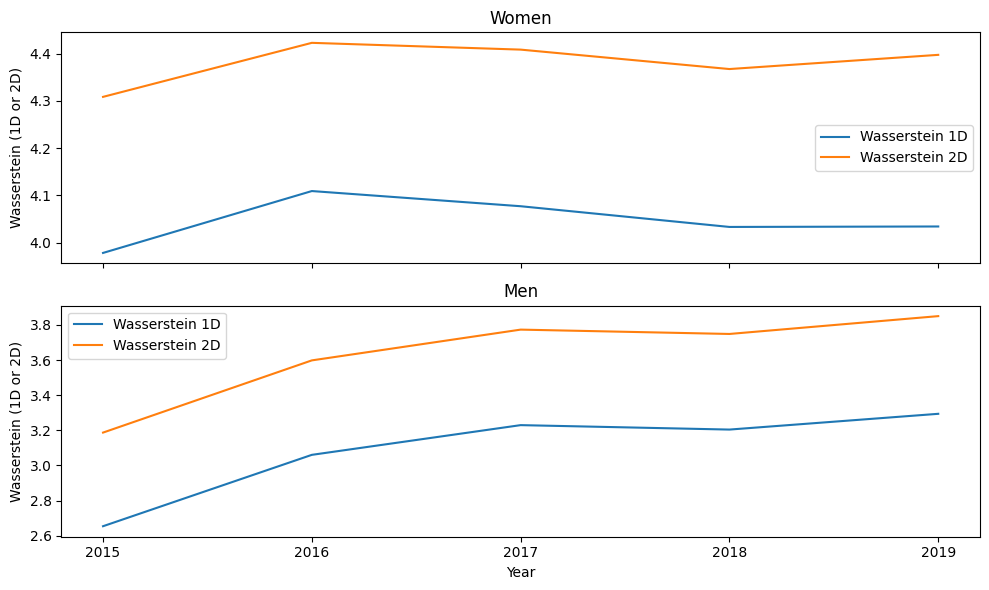

In [20]:
# Ensure proper sorting
df_plot = Wasserstein_results.sort_values("year")

# Split by sex
df_men   = df_plot[df_plot["sex"] == 1]
df_women = df_plot[df_plot["sex"] == 2]

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(10, 6)
)

# Women
axes[0].plot(df_women["year"], df_women["W_all_scipy"], label="Wasserstein 1D")
axes[0].plot(df_women["year"], df_women["W_joint"], label="Wasserstein 2D")
axes[0].set_title("Women")
axes[0].set_ylabel("Wasserstein (1D or 2D)")
axes[0].legend()

# Men
axes[1].plot(df_men["year"], df_men["W_all_scipy"], label="Wasserstein 1D")
axes[1].plot(df_men["year"], df_men["W_joint"], label="Wasserstein 2D")
axes[1].set_title("Men")
axes[1].set_ylabel("Wasserstein (1D or 2D)")
axes[1].set_xlabel("Year")
axes[1].legend()

# Force integer year ticks
for ax in axes:
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


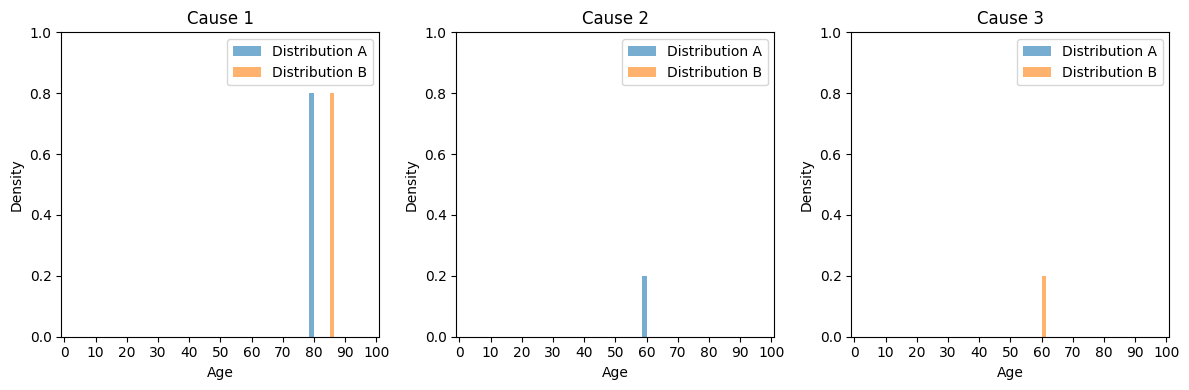

In [21]:
# toy example 2D
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ages = np.arange(0, 101)


bar_width = 1.2  
half_width = bar_width / 2

color_A = 'tab:blue'
color_B = 'tab:orange'

def plot_pair(ax, distA, distB, title, width=1.2):
    half_width = width / 2  
    ax.bar(ages - half_width/2, distA, width=half_width, alpha=0.6, label='Distribution A', color=color_A)
    ax.bar(ages + half_width/2, distB, width=half_width, alpha=0.6, label='Distribution B', color=color_B)
    ax.set_xlabel('Age')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.set_xlim(-1, 101)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.legend()

# --- Cause 1 ---
distA_c1 = np.zeros_like(ages, dtype=float)
distB_c1 = np.zeros_like(ages, dtype=float)
distA_c1[80] = 0.8
distB_c1[85] = 0.8
plot_pair(axes[0], distA_c1, distB_c1, 'Cause 1', width=3)

# --- Cause 2 ---
distA_c2 = np.zeros_like(ages, dtype=float)
distB_c2 = np.zeros_like(ages, dtype=float)
distA_c2[60] = 0.2
distB_c2[60] = 0
plot_pair(axes[1], distA_c2, distB_c2, 'Cause 2', width=3)

# --- Cause 3 ---
distA_c3 = np.zeros_like(ages, dtype=float)
distB_c3 = np.zeros_like(ages, dtype=float)
distA_c3[60] = 0
distB_c3[60] = 0.2
plot_pair(axes[2], distA_c3, distB_c3, 'Cause 3', width=3)

plt.tight_layout()
plt.savefig('Toyexample_causes_2d.png', dpi=300, bbox_inches='tight')  
plt.show()


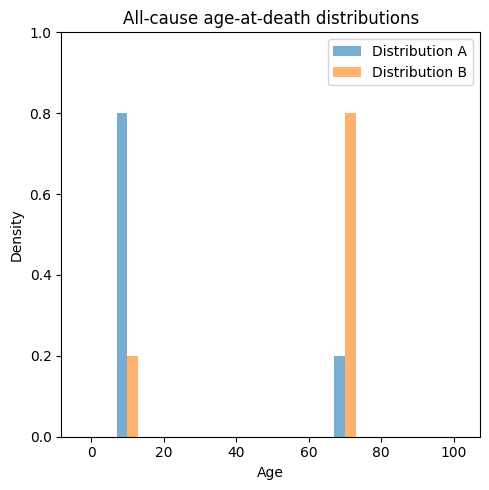

In [22]:
# toy example 1D
ages = np.arange(0, 100)  

distA = np.zeros_like(ages, dtype=float)
distB = np.zeros_like(ages, dtype=float)

distA[10] = 0.8
distA[70] = 0.2

distB[10] = 0.2
distB[70] = 0.8

plt.figure(figsize=(5, 5))

bar_width = 3  

plt.bar(ages - bar_width/2, distA, 
        width=bar_width, alpha=0.6, label="Distribution A", color = "tab:blue")

plt.bar(ages + bar_width/2, distB, 
        width=bar_width, alpha=0.6, label="Distribution B", color = "tab:orange")

plt.xlabel("Age")
plt.ylabel("Density")
plt.title("All-cause age-at-death distributions")
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()


plt.savefig('Toyexample_causes.png', dpi=300, bbox_inches='tight')  

plt.show()